# Using *ceffyl* on for a GFL Lite analysis

Refitting spectra to combinations of single pulsar free spectra is easy using *ceffyl*. Simply choose your spectrum from *ceffyl.model* (or create your own function!), along with the number of frequencies that you want to search over, and your pulsars, and let your MCMC run!

First off, let's import some required packages...

In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from chainconsumer.chainconsumer import ChainConsumer
from ceffyl import Ceffyl, models, Sampler, chain_utils
from enterprise.signals import parameter
import ultranest

import la_forge.core as co
import la_forge.diagnostics as dg

Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


## GFL Lite single pulsar free spectra

The free spectrum is a model-independent analysis of the timing residuals from a single pulsar [(Lentati et. al. 2013)](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.87.104021). For a GFL Lite-style analysis, we model a pulsar's intrinsic red noise as a 30 frequency power-law, and include a free-spectrum process to represent excess noise due to a common process. We recover posteriors at each sampled GW frequency that represents the common process' cross-power spectrum at that frequency bin for that pulsar. The posteriors are represented by the coefficient $\rho$, where $$\rho^2(f_k) = \frac{S_{p}(f_k)}{T}$$ for a pulsar $p$ at a frequency bin $f_k$ for $k \in [1, N_f]$, $S$ is the timing-residual cross-power spectrum, and $T$ is the PTA timing baseline.

Since we have modelled intrinsic red noise for each pulsar, we simply fit a common process across our array.

We run the free spectrum with [`enterprise`](https://github.com/nanograv/enterprise) on each individual pulsar.

The injected values for this simulation are:

In [15]:
log10A_inj, gamma_inj = np.loadtxt('../data/sim51/injected_values.txt')
print(f'log10A={log10A_inj}, gamma={gamma_inj}')

log10A=-14.6985, gamma=4.1727


## Now let's fit some GW models!

To fit our GW models onto our single pulsar free spectra, we must represent our posteriors as probability density functions in order to extract probabilities to build a Bayesian likelihood. Using the most optimal kernel density estimators (KDEs, see paper for details), we can create a grid of probabilities to select from.

For details on creating your own probability grids, see [link to another ipynb being developed]. However, these grids will be made for you in advance for most PTA data sets so all you have to do is use them! :)

let's initialise a Ceffyl object to approximate a PTA using the GFL Lite-style free spectra. A directory containing the KDE densities of our simulated PTA free spectrum is our input. It also contains metadata on the frequencies used, pulsar names etc.

In [2]:
pta = Ceffyl.ceffyl(datadir='../data/sim51/GFL_lite_sim51/')

Ceffyl already knows that this data set will be running a GFL-style analysis from this data set because we have KDEs across frequencies AND pulsars.

Define a GW spectrum! Let's try a 5f powerlaw. The default parameters here are $\log_{10}A\in[-18,-12]$, $\gamma\in[0,7]$. This function assumes all pulsars will be used.

In [3]:
gw = Ceffyl.signal(psd=models.powerlaw, N_freqs=5)

Adding signals is easy!

In [5]:
pta.add_signals([gw])

Now let's setup and run our sampler

In [6]:
sampler = Sampler.setup_sampler(pta, 
                                outdir='../data/sim51/refits/gfl_lite/5fpl/',
                                logL=pta.ln_likelihood,
                                logp=pta.ln_prior, resume=False)
x0 = pta.initial_samples()  # get initial sample

Adding GWB uniform distribution draws...



In [10]:
sampler.sample(x0, int(200000))  # sample!

/Users/lambwg/Applications/miniconda3/envs/enterprise/lib/python3.10/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 5.00 percent in 3.225582 s Acceptance rate = 0.146378Adding DE jump with weight 20
Finished 99.50 percent in 65.152740 s Acceptance rate = 0.211281
Run Complete


##### Let's read the data

In [11]:
# this compresses the output file
c0 = co.Core('../data/sim51/refits/gfl_lite/5fpl/')
c0.set_rn_freqs(Tspan=1/pta.freqs[0], nfreqs=5)
c0.save('../data/sim51/refits/gfl_lite/5fpl/chain.core')
pl5f = co.Core(corepath='../data/sim51/refits/gfl_lite/5fpl/chain.core')

checking the traceplot to see if the chains converged

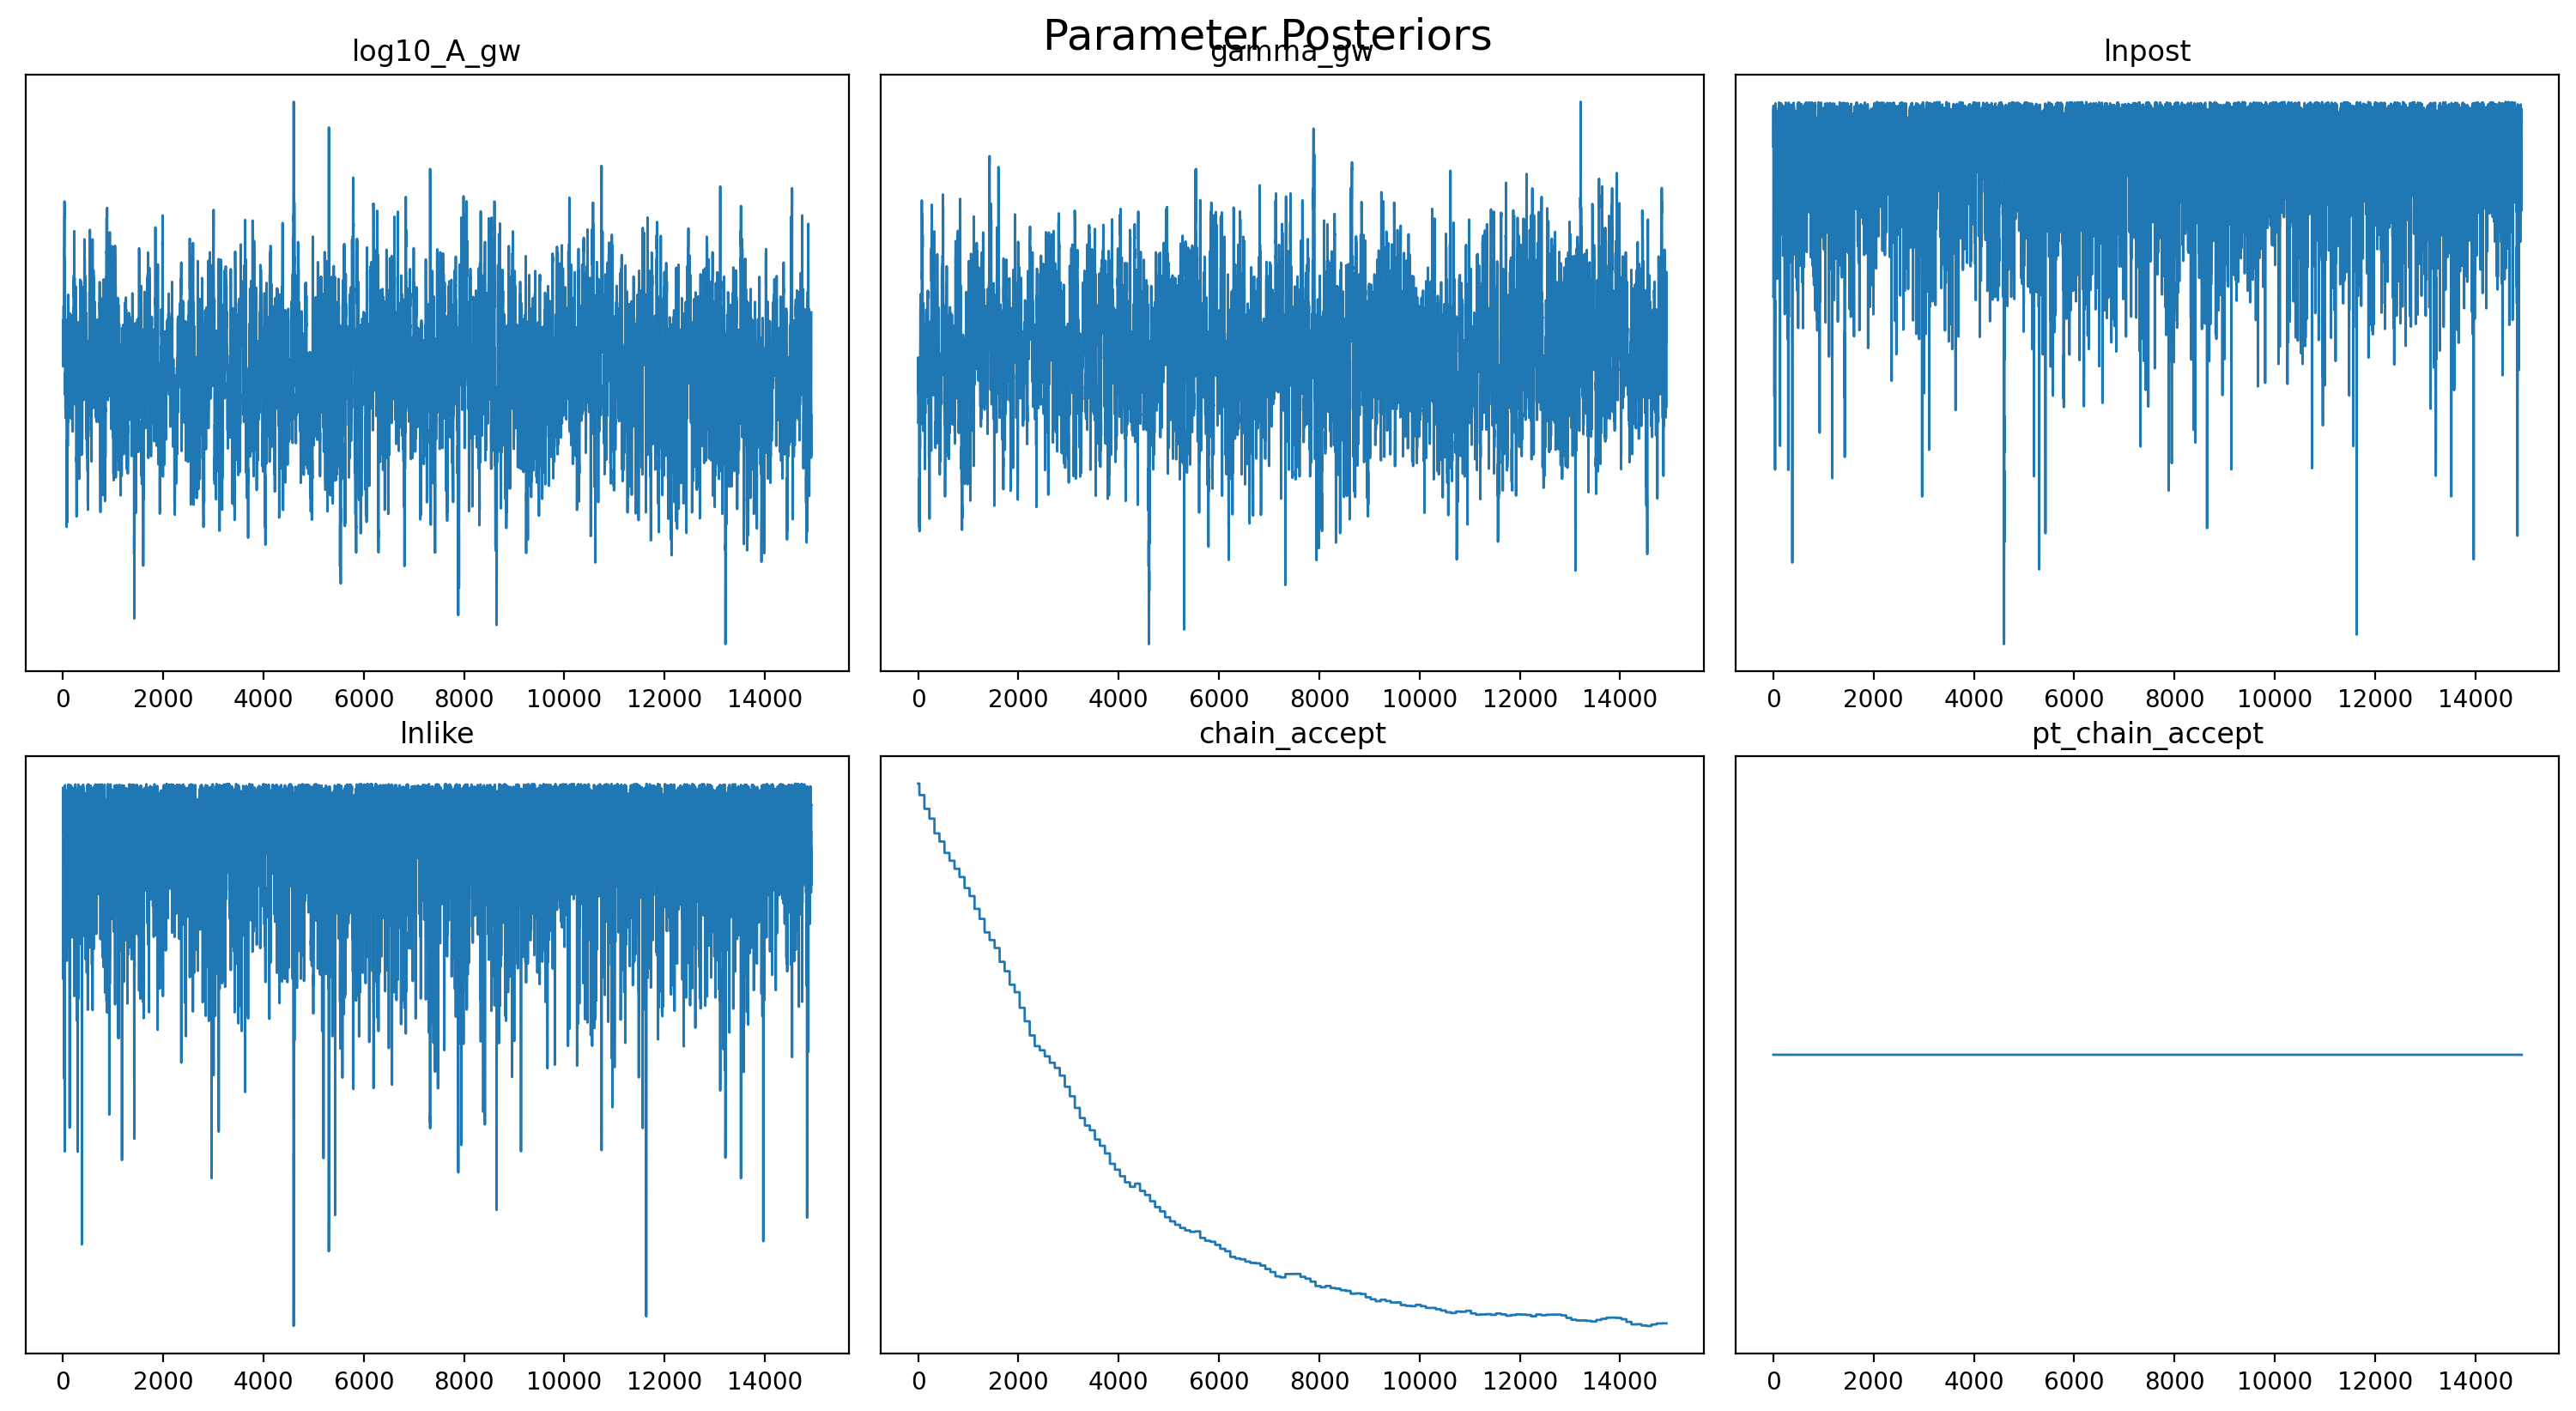

In [12]:
dg.plot_chains(pl5f, hist=False)

let's also numerical check if it has converged. If all points are below the dashed line, we are good to go (but to be safe, you should also check if all parameters have small autocorrelations lengths too by using `emcee.autocorr`

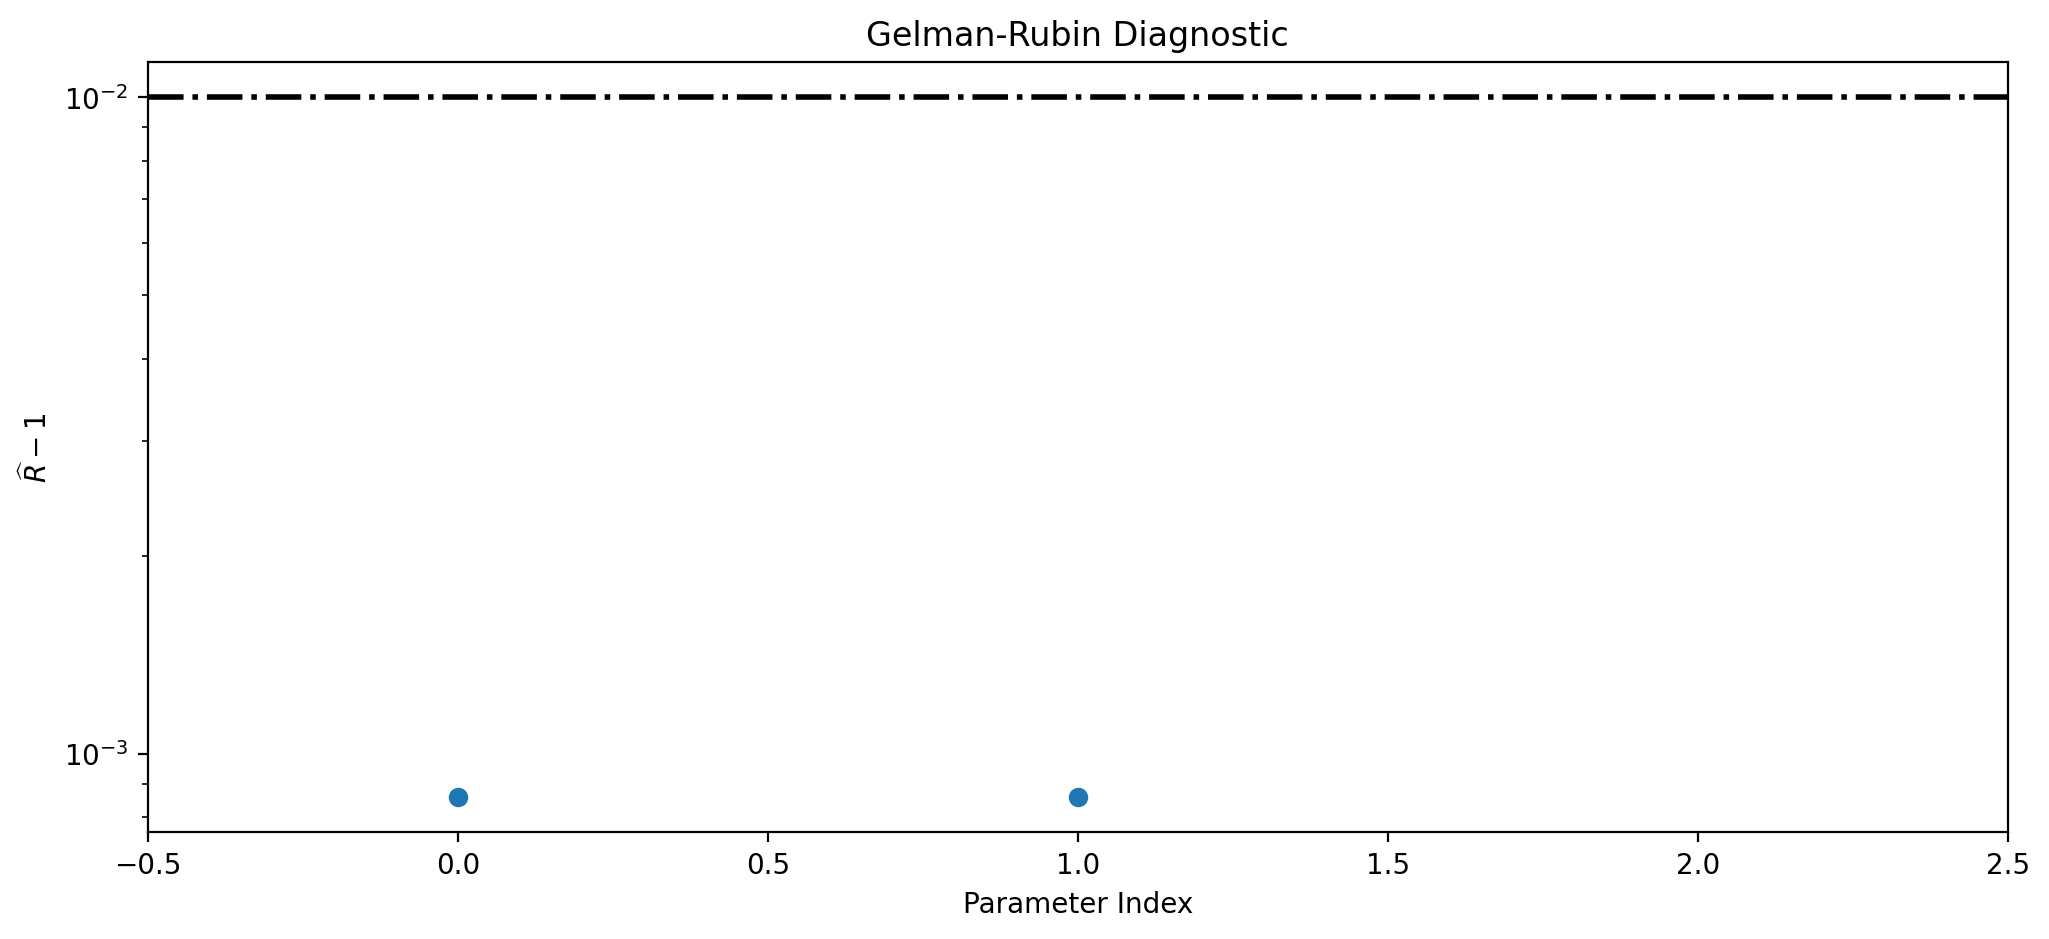

In [13]:
dg.plot_grubin(pl5f)

Let's make a corner plot!

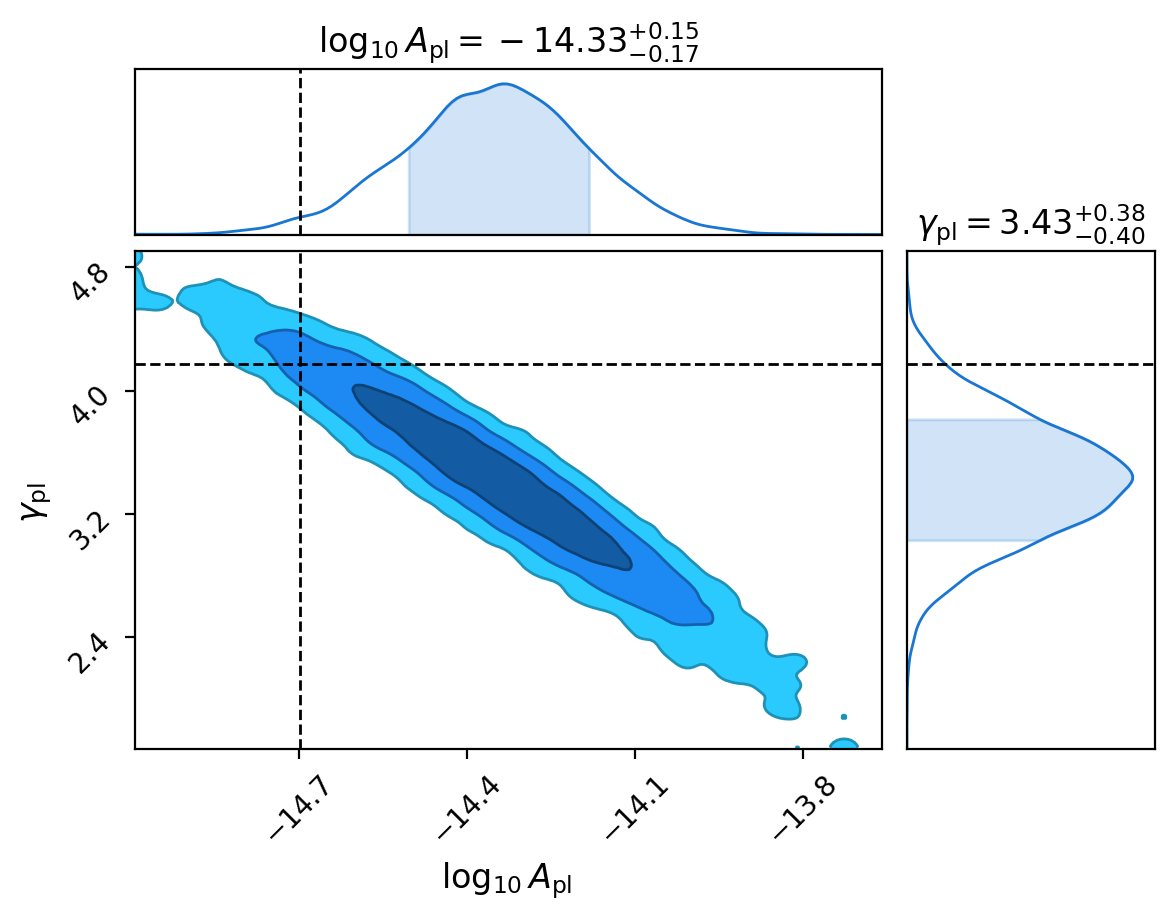

In [16]:
tex = [r'$\log_{10}A_\mathrm{pl}$', r'$\gamma_\mathrm{pl}$']

c = ChainConsumer()
c.add_chain(pl5f(pl5f.params[:2]),
            parameters=tex)
c.configure(usetex=False, summary=True, sigmas=[1,2,3])
c.plotter.plot(figsize=(6,4), truth=[log10A_inj, gamma_inj]);

The 'truth' lines are the injected powerlaw parameters. Our analysis captures the injection well within the 95% credible region. This is good, but we should compare it to a typical uncorrelated powerlaw analysis. See Fig 3. of [Lamb, Taylor & van Haasteren 2023]().

##### What if I want to try a different combination of pulsars?

Then just submit a list of pulsars that you want to fit!

Let's try a broken powerlaw with *fixed* $\gamma$?
We fix a value by defining it in the dictionary labelled `const_params`.

In [41]:
# initialise ceffyl
pta2 = Ceffyl.ceffyl(datadir='../data/sim51/GFL_lite_sim51/')

let's select 25 random pulsars from our list

In [42]:
print(pta2.pulsar_list)

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J0340+4130', 'J0613-0200', 'J0636+5128', 'J0645+5158', 'J0740+6620', 'J0931-1902', 'J1012+5307', 'J1024-0719', 'J1125+7819', 'J1453+1902', 'J1455-3330', 'J1600-3053', 'J1614-2230', 'J1640+2224', 'J1643-1224', 'J1713+0747', 'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1747-4036', 'J1832-0836', 'J1853+1303', 'J1903+0327', 'J1909-3744', 'J1910+1256', 'J1911+1347', 'J1918-0642', 'J1923+2515', 'J1944+0907', 'J2010-1323', 'J2017+0603', 'J2033+1734', 'J2043+1711', 'J2145-0750', 'J2214+3000', 'J2229+2643', 'J2234+0611', 'J2234+0944', 'J2302+4442', 'J2317+1439']


In [43]:
# select random 25
select_psrs = np.random.choice(pta2.pulsar_list, 25)
select_psrs

array(['J2234+0944', 'J2043+1711', 'J2017+0603', 'J1600-3053',
       'J1455-3330', 'J1909-3744', 'J2317+1439', 'J0931-1902',
       'J0030+0451', 'J1909-3744', 'J0645+5158', 'J2043+1711',
       'J2317+1439', 'J0645+5158', 'J1640+2224', 'J1643-1224',
       'J1455-3330', 'J2010-1323', 'B1937+21', 'J0613-0200', 'B1937+21',
       'J1747-4036', 'J1747-4036', 'J0636+5128', 'J0931-1902'],
      dtype='<U10')

In [53]:
# first we need to define some priors on log10_A and the break frequency, log10_fb
# it's just like defining priors in a standard enterprise run!
log10A = parameter.Uniform(-18, -12)('log10_A')
log10_fb = parameter.Uniform(-9, -7)('log10_fb')

# then we define gamma as a constant float
const_params = dict(gamma=gamma_inj)

# then we choose our model
psd = models.broken_powerlaw

we reinitialise our pta with our selected psrs here

In [54]:
# initialise ceffyl
pta2 = Ceffyl.ceffyl(datadir='../data/sim51/GFL_lite_sim51/',
                     pulsar_list=select_psrs)

In [55]:
# and the create our signal! Let's try 10 frequencies and add our selected psrs
gw = Ceffyl.signal(N_freqs=10, psd=psd,
                   params=[log10A, log10_fb],
                   const_params=const_params)

In [56]:
pta2.add_signals([gw])

In [57]:
# and finally, we setup the sampler!
sampler = Sampler.setup_sampler(pta2,
                                outdir='../data/sim51/refits/gfl_lite/10fbpl_25psrs/',
                                logL=pta2.ln_likelihood,
                                logp=pta2.ln_prior, resume=False)
x0 = pta2.initial_samples()  # get initial sample
sampler.sample(x0, int(200000))

Adding GWB uniform distribution draws...



/Users/lambwg/Applications/miniconda3/envs/enterprise/lib/python3.10/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 5.00 percent in 3.633563 s Acceptance rate = 0.275956Adding DE jump with weight 20
Finished 99.50 percent in 57.016454 s Acceptance rate = 0.423261
Run Complete


##### read the chain and run convergence tests...

In [58]:
c0 = co.Core('../data/sim51/refits/gfl_lite/10fbpl_25psrs/')
c0.set_rn_freqs(Tspan=1/pta.freqs[0], nfreqs=10)
c0.save('../data/sim51/refits/gfl_lite/10fbpl_25psrs/chain.core')
bpl10f = co.Core(corepath='../data/sim51/refits/gfl_lite/10fbpl_25psrs/chain.core')

INFO:la_forge.core:Appending ['lnpost','lnlike','chain_accept','pt_chain_accept'] to end of params list.


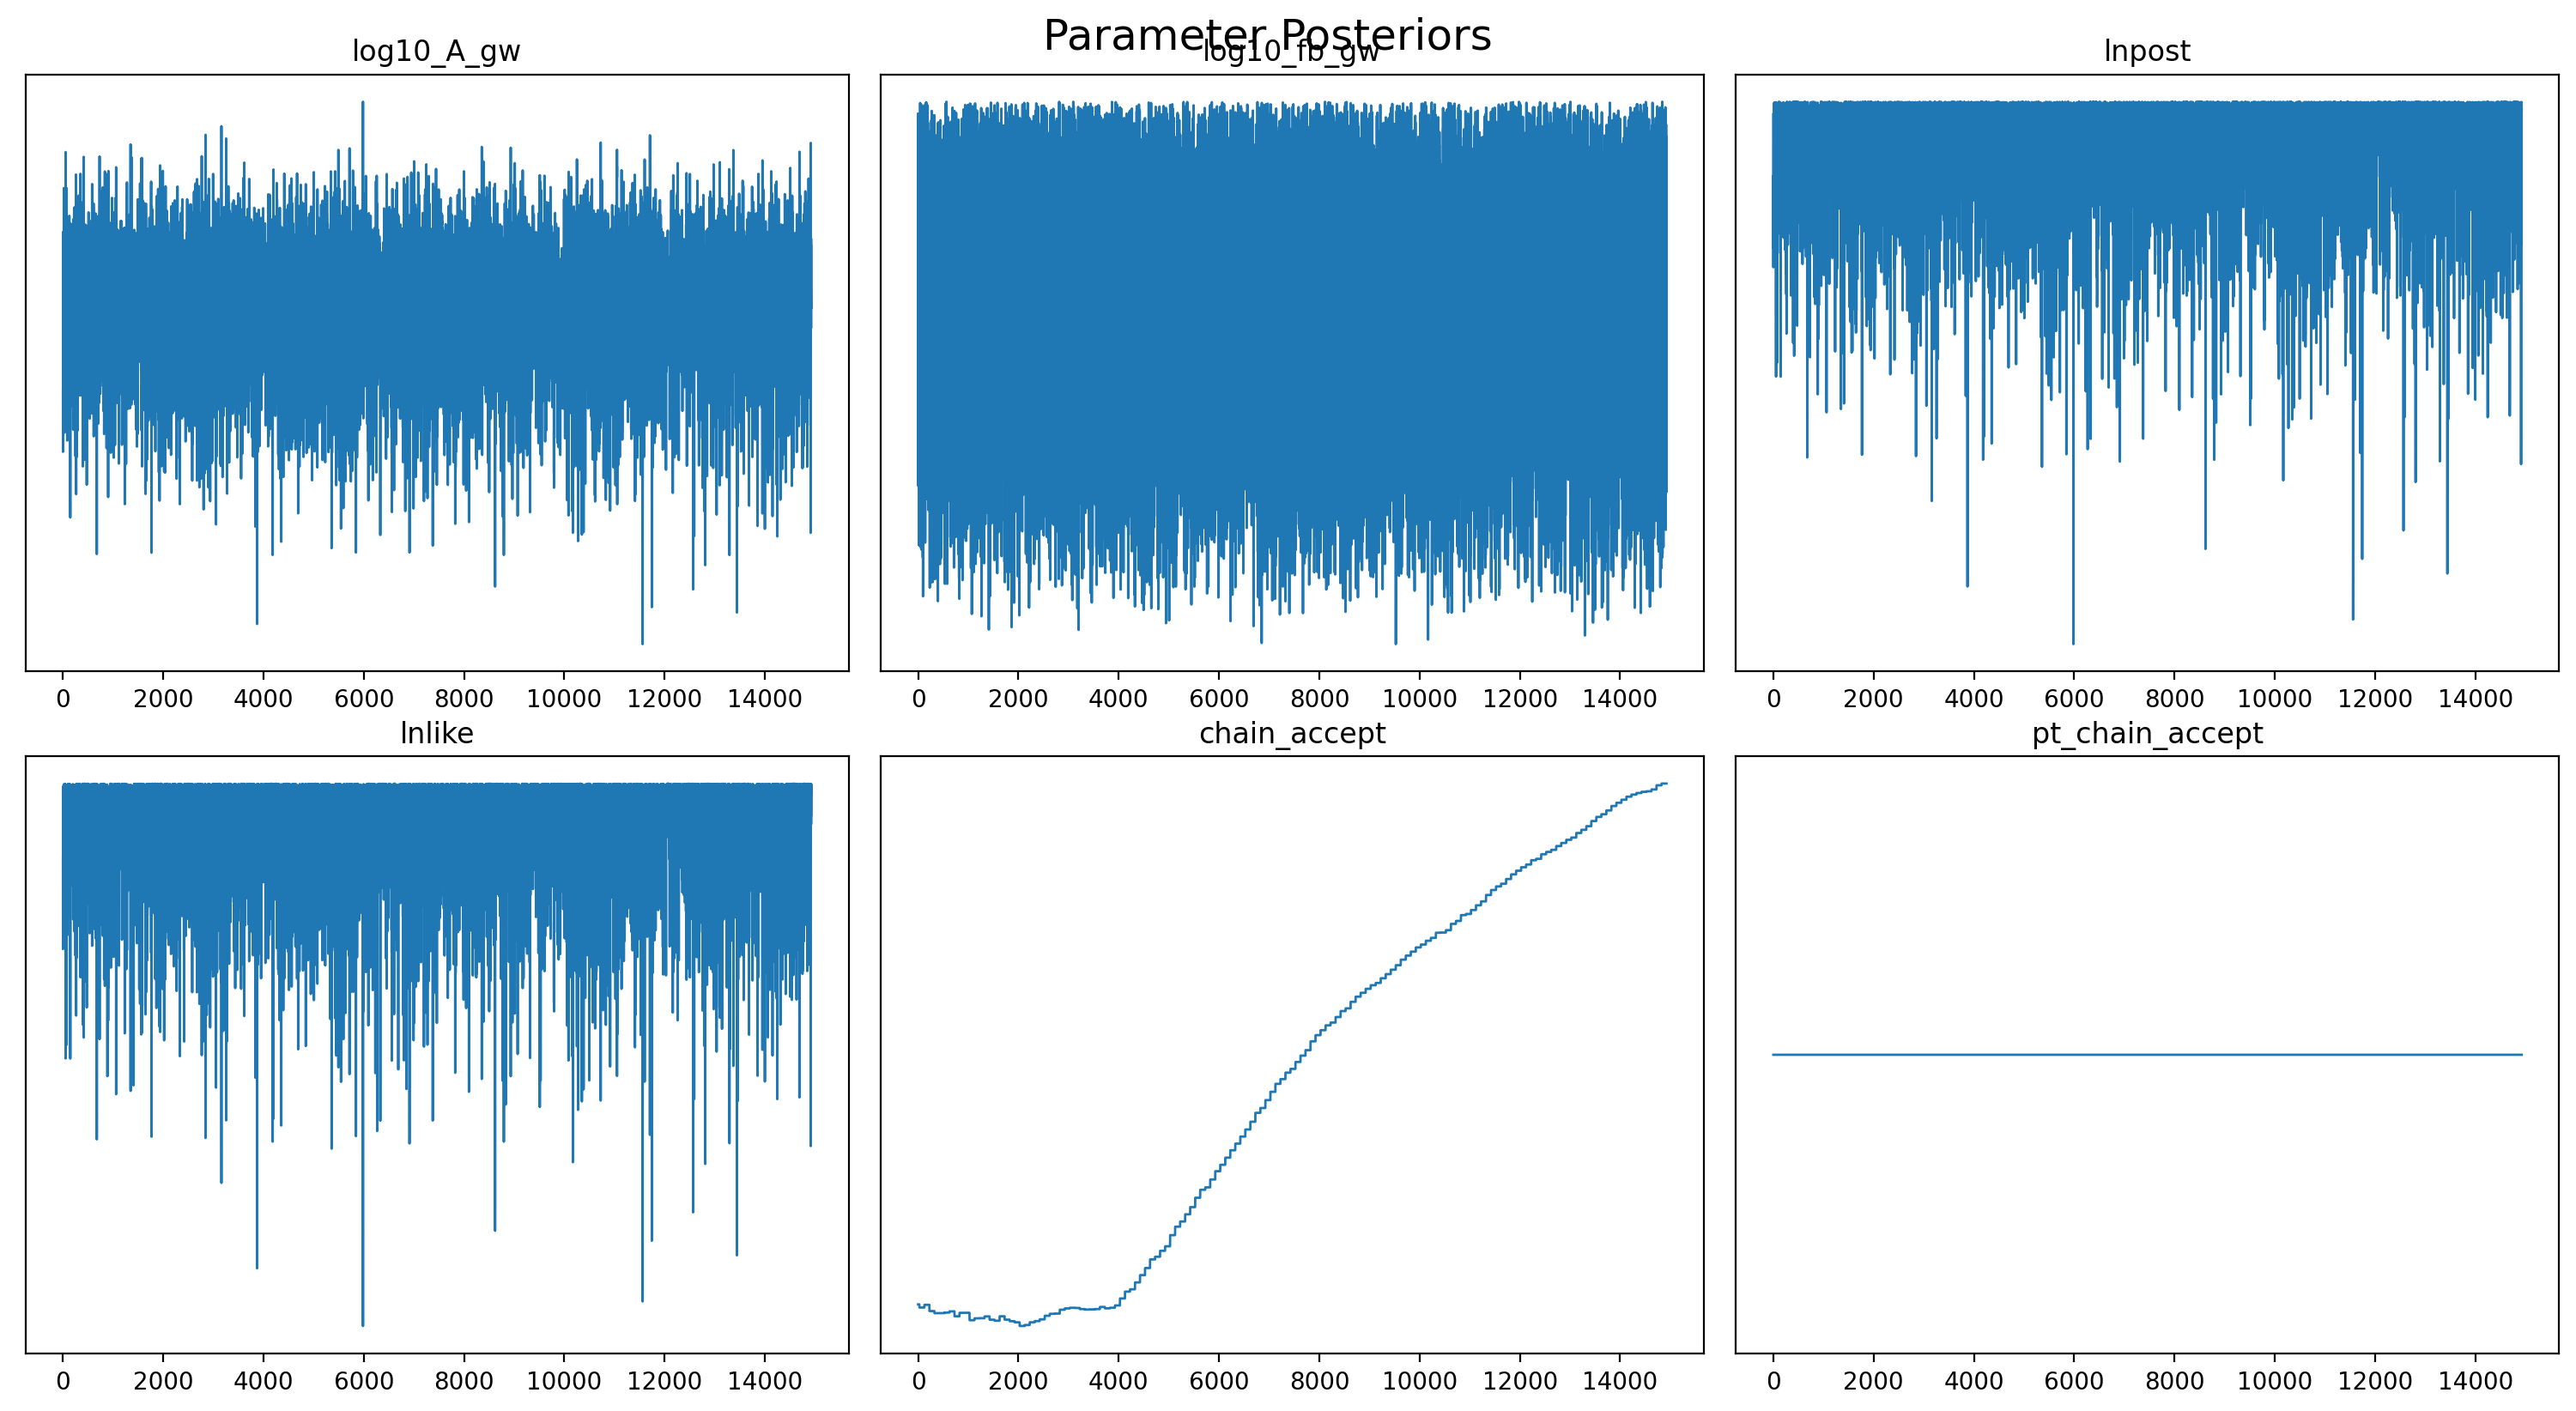

In [59]:
# checking the traceplot
dg.plot_chains(bpl10f, hist=False)

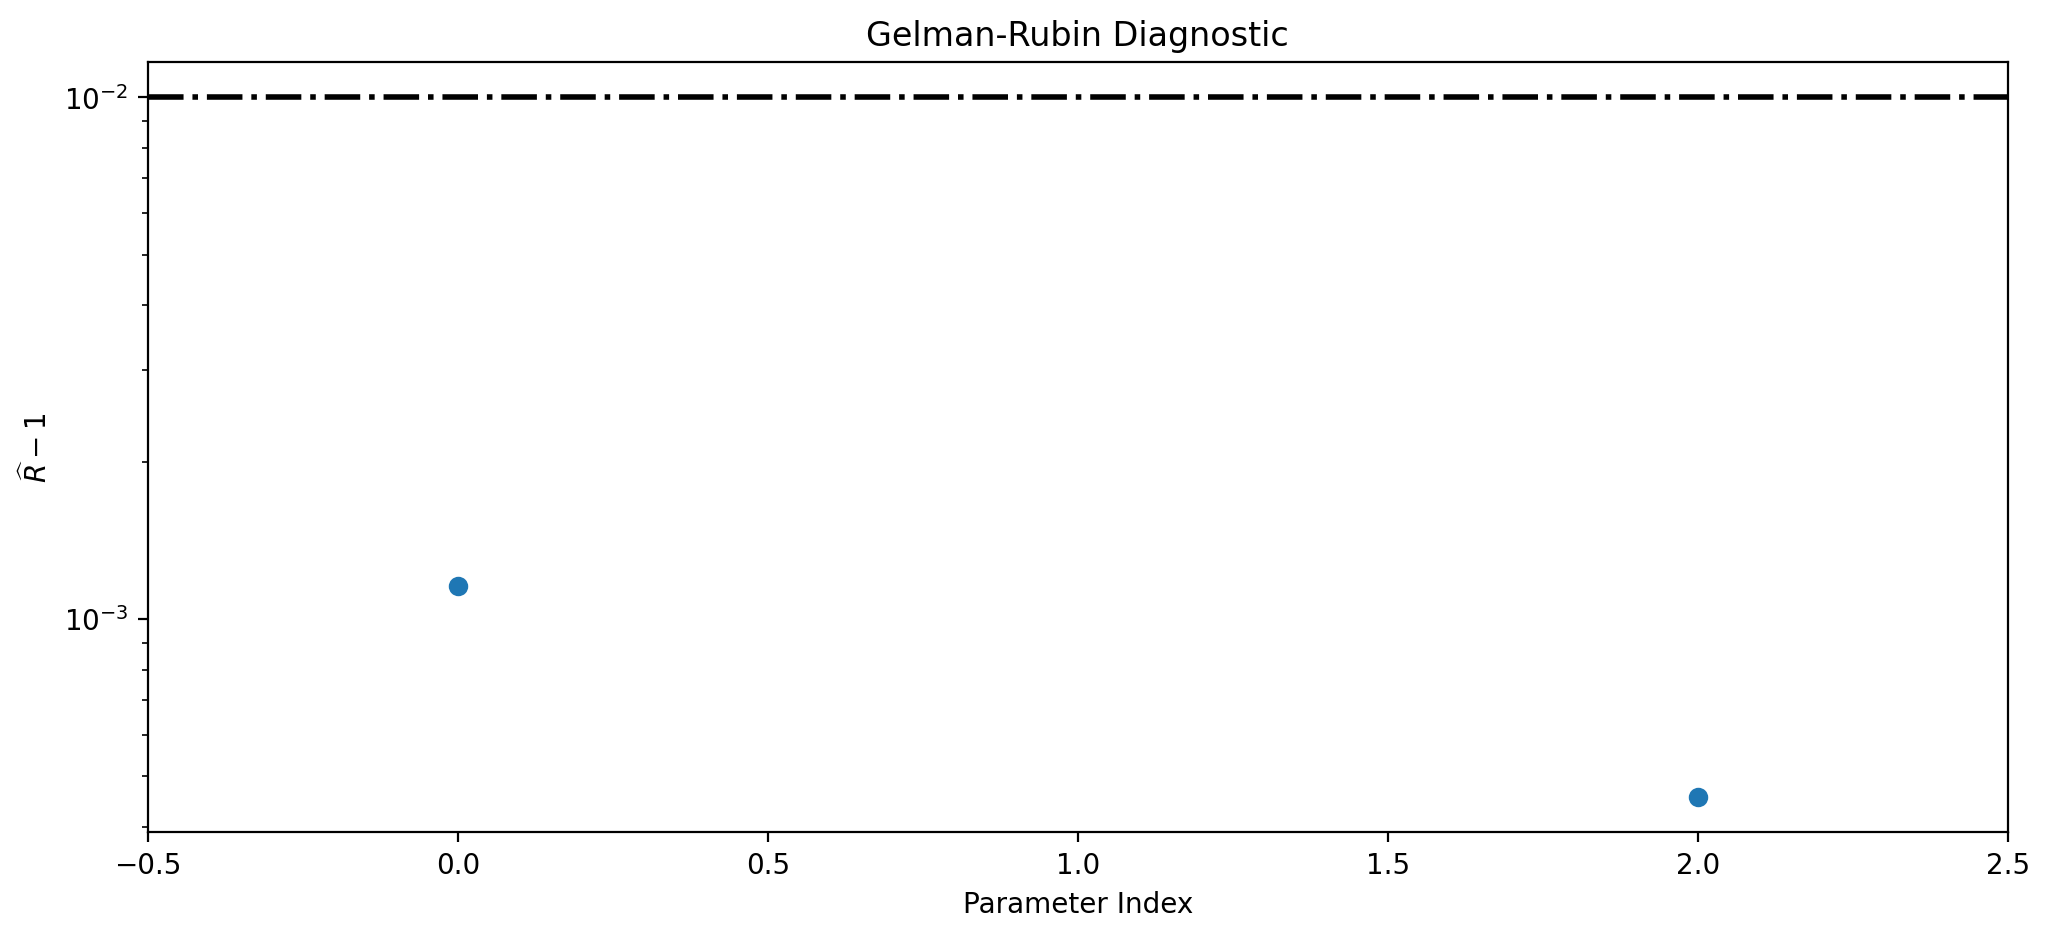

In [60]:
dg.plot_grubin(bpl10f)

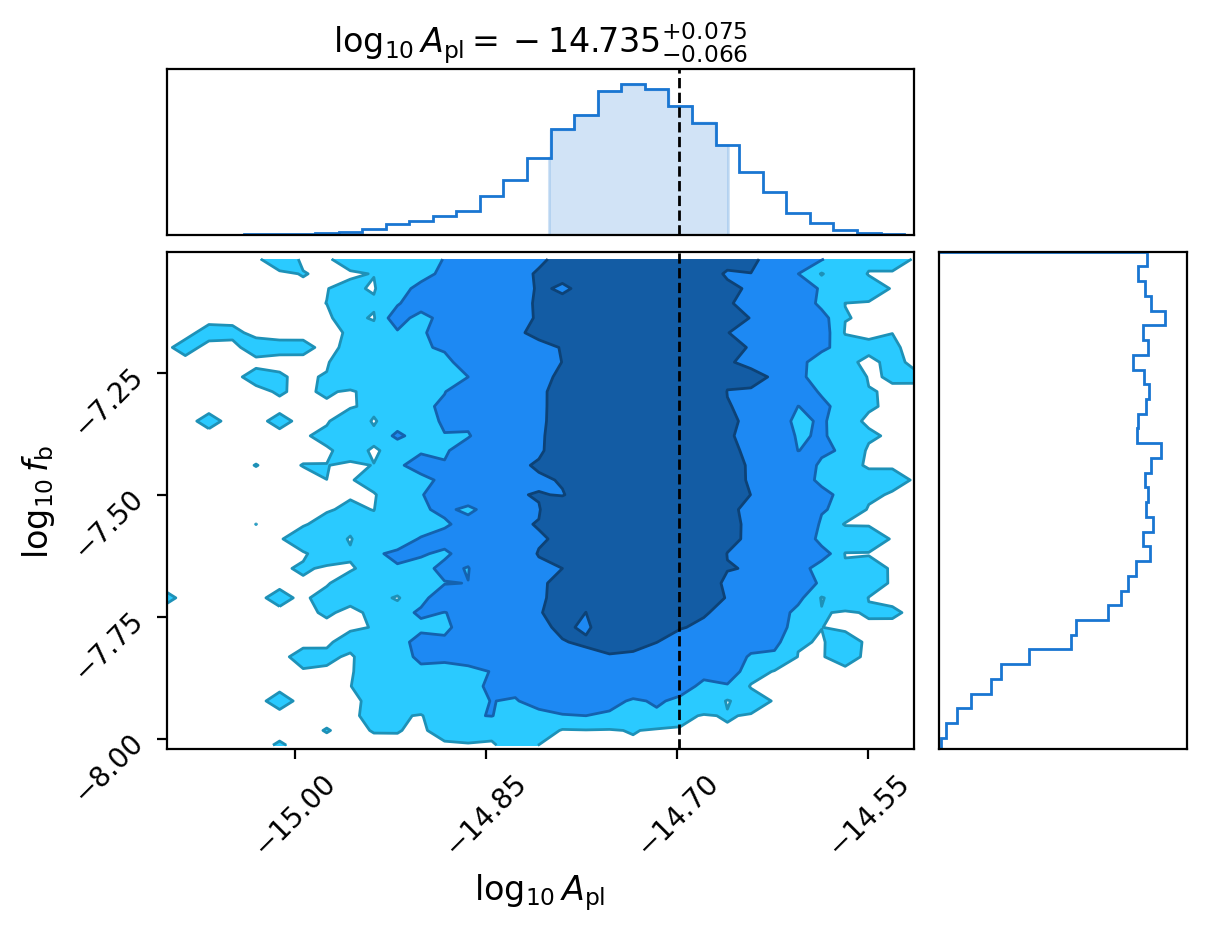

In [61]:
# let's make a corner plot!
tex = [r'$\log_{10}A_\mathrm{pl}$', r'$\log_{10}f_\mathrm{b}$']

c = ChainConsumer()
c.add_chain(bpl10f(bpl10f.params[:2]),
            parameters=tex)
c.configure(usetex=False, summary=True, sigmas=[1,2,3],
            smooth=False)
c.plotter.plot(figsize=(6,4), truth=[log10A_inj]);

##### Defining your own spectrum model

Defining your own spectrum model is really easy! The function just needs to follow some standard input/output rules to make sure it works properly in $\textit{ceffyl}$!

First rule: the first two arguments should be `f` (an array of frequencies) and `Tspan` (the timespan of the data set).

Second rule: the input array `f` has shape ($N_f$, 1) for the PTA free spectrum analysis. This is for vectorisation purposes. You can find this array as `pta.reshaped_freqs`. The output spectrum should therefore result in a ($N_f$, 1) vector.

In [25]:
pta.reshaped_freqs.shape

(10, 1)

In [26]:
models.powerlaw(pta.reshaped_freqs, pta.Tspan).shape

(10, 1)

The arguments after `f` and `Tspan` can then be anything you want!

The returned function must be in units of $[s^2]$ corresponding to $\rho^2$, just like in `enterprise.gp_priors`.